## cGAN convergence evaluation

Attempt-3

Interesting result, but insufficient. I'm guessing the generator simply wasn't able to produce sufficiently *real* results. I'll try a more-powerful network.

In [1]:
# get data from storage 
! gsutil cp gs://gdax-dnn-tmp-1/cgan-statistics.pkl .
! gsutil cp gs://gdax-dnn-tmp-1/cgan-model.h5 .

Copying gs://gdax-dnn-tmp-1/cgan-statistics.pkl...
/ [1 files][601.2 KiB/601.2 KiB]                                                
Operation completed over 1 objects/601.2 KiB.                                    
Copying gs://gdax-dnn-tmp-1/cgan-model.h5...
/ [1 files][  6.7 MiB/  6.7 MiB]                                                
Operation completed over 1 objects/6.7 MiB.                                      


In [2]:
# missing dependencies 
import sys
! pip install --user tensorflow
! pip install --user keras
sys.path.append('/home/jupyter/.local/lib/python3.5/site-packages')

     |████████████████████████████████| 421.8 MB 17 kB/s s eta 0:00:01��███████████▌| 414.8 MB 80.7 MB/s eta 0:00:01
     |████████████████████████████████| 448 kB 62.7 MB/s eta 0:00:01
     |████████████████████████████████| 104 kB 9.2 kB/s  eta 0:00:01
     |████████████████████████████████| 41 kB 1.0 MB/s  eta 0:00:01
     |████████████████████████████████| 57 kB 6.7 MB/s  eta 0:00:01
     |████████████████████████████████| 69 kB 5.7 MB/s  eta 0:00:01
     |████████████████████████████████| 50 kB 8.3 MB/s  eta 0:00:01
     |████████████████████████████████| 19.9 MB 48.3 MB/s eta 0:00:01
     |████████████████████████████████| 3.8 MB 33.9 MB/s eta 0:00:01
     |████████████████████████████████| 26.0 MB 72.9 MB/s eta 0:00:01
  Created wheel for absl-py: filename=absl_py-0.9.0-py3-none-any.whl size=119398 sha256=96ce238154078f8cdc2f1485719bffcf41a93e1e01d60a01e7e75f9120a5398b
  Stored in directory: /home/jupyter/.cache/pip/wheels/00/c0/fe/b499a8663e1697aa205f83a8b15a53a29dc4b9831643b00

In [3]:
import pickle
with open('cgan-statistics.pkl', 'rb') as f:
    stats = pickle.load(f)

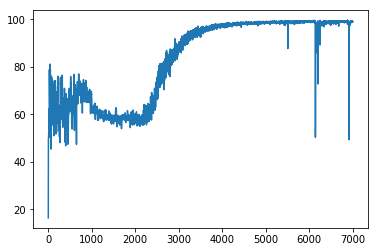

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_stat(stat):
    plt.plot(stats[stat])
    plt.show()
    pass

plot_stat('acc')

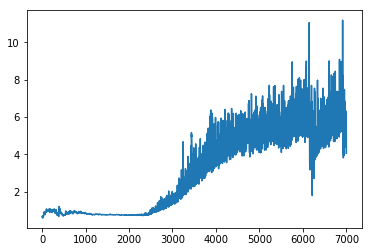

In [5]:
plot_stat('g_loss')

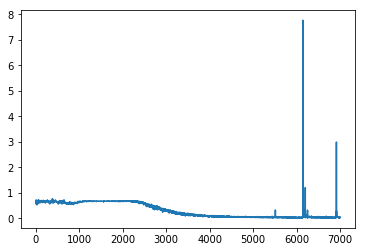

In [6]:
plot_stat('d_loss')

Convergence looks good. So, we'll finish this analysis with simulation histograms. 

In [7]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
import numpy as np

def build_generator(latent_dim=100, img_shape=(1024, 1), num_classes=3):
    model = Sequential()
    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape)))
    model.add(Reshape(img_shape))
    model.add(ReLU(negative_slope=0.2, threshold=0.))
    model.summary()
    noise = Input(shape=(latent_dim,))
    label = Input(shape=(1,), dtype='int32')
    label_embedding = Flatten()(Embedding(num_classes, latent_dim)(label))
    model_input = multiply([noise, label_embedding])
    img = model(model_input)
    return Model([noise, label], img)

gen = build_generator()
gen.load_weights('cgan-model.h5')

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 1024)             

In [8]:
def hist(x, num_bins=50, **kwargs):
    plt.hist(x, num_bins, **kwargs)
    plt.show()
    pass

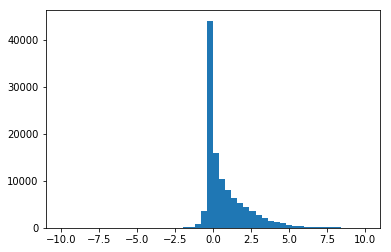

In [9]:
# Dead and not rewarded (0.4%)
y = gen.predict([np.random.normal(0, 1, (111, 100)), 0*np.ones(111)]).flatten()
hist(y,range=(-10,10))

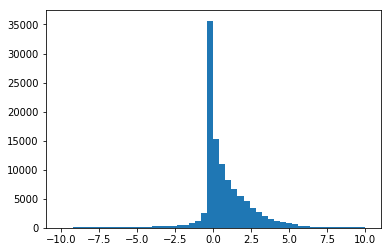

In [10]:
# Not dead and rewarded (3%)
y = gen.predict([np.random.normal(0, 1, (111, 100)), 1*np.ones(111)]).flatten()
hist(y,range=(-10,10))

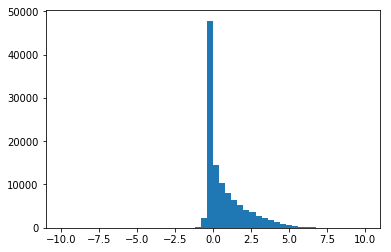

In [11]:
# Not dead and rewarded (96.6%)
y = gen.predict([np.random.normal(0, 1, (111, 100)), 2*np.ones(111)]).flatten()
hist(y,range=(-10,10))

In [81]:
! gsutil cp gs://gdax-dnn-tmp-1/cgan-data.pkl-backup .

Copying gs://gdax-dnn-tmp-1/cgan-data.pkl-backup...
/ [1 files][  1.5 GiB/  1.5 GiB]   23.7 MiB/s                                   
Operation completed over 1 objects/1.5 GiB.                                      


In [82]:
with open('cgan-data.pkl', 'rb') as f:
    cgan_data = pickle.load(f)

In [83]:
idx = np.random.choice(cgan_data[0].shape[0], 100)
x = cgan_data[0][idx,:] + 3.5

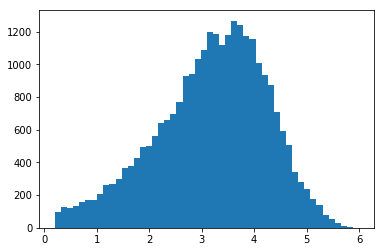

In [84]:
hist(x.flatten(), range=(.2, 6))

In [68]:
x += 3.5